<a href="https://colab.research.google.com/github/alanbseo/MFAworkshop/blob/main/MFA_3_EmbeddedCarbon_Plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MFA workshop 세 번째 세션. 이번에는 Material to Carbon 테이블을 읽고 Embedded Carbon을 계산해 보도록 하자.

## Colab 기본 설정


In [ ]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np


# import pandas and geopandas package
import pandas as pd

try:
  import geopandas as gpd
except: # 설치되어 있지 않을 경우 이리로 분기하여 패키지를 설치
  !pip install geopandas
  import geopandas as gpd

# import rasterio pacakge
try:
  import rasterio
except:
  !pip install rasterio
  import rasterio

# import required functions
from rasterio import transform
from rasterio import features
from rasterio.enums import Resampling


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Mount Gdrive
# 이번에는 이미 마운트 되어 있는지 확인하고
if not (os.path.exists('/content/gdrive/')):
  print("Mount Gdrive")
  drive.mount('/content/gdrive/') # 마운트 되어있지 않을 때만 다시 시도


# set working directory
default_path = '/content/gdrive/MyDrive/Net zero built environment/MFA workshop' # 이 경로는 사용자 마다 상이할 수 있음

print("Change working directory to the Google Drive folder")
os.chdir(default_path)
print(os.getcwd()) # print the current working directory


Mount Gdrive
Mounted at /content/gdrive/
Change working directory to the Google Drive folder
/content/gdrive/.shortcut-targets-by-id/1gDT-7hKMl37JnTVecJLmI9yB2rUI7rAo/Net zero built environment/MFA workshop


## 지난 시간에 만든 건축면적(gross area)와 구조코드를 읽어들이자.

In [ ]:
# Read the rasterised Volume and Code data
code_out_fn = './images/code_100m.tif'

with rasterio.open(code_out_fn) as src:
    #print(src.profile)
    code_img = src.read(1)

###
# 0: NA
# 11: Brick
# 12: Block
# 19: Other masonry structure (기타조적구조)
# 21: Reinforced concrete
# 31: Steel (일반철골구조)
# 40: Steel reinforced concrete
# 41: Steel concrete (철골콘크리트)
# 42: Steel reinforced concrete (== 40?)
# 51: Wood (일반목구조)
# 99: Other

In [ ]:
# Gross area data for Jongno-gu (Feb 2023)
path_data_grossarea = "Data/Data_100m/Jongno-gu/(B100)국토통계_건축물-연면적-(격자) 100M_서울특별시 종로구_202303/nlsp_021002006.shp"
grossarea_gdf = gpd.read_file(path_data_grossarea, encoding = "UTF-8")
print(grossarea_gdf.columns) # 컬럼 이름
print(grossarea_gdf.head()) # 이번 경우에는 lbl과 val에 같은 값이 들어있네요

Index(['gid', 'lbl', 'val', 'geometry'], dtype='object')
        gid      lbl      val  \
0  다사551532   120.21   120.21   
1  다사564526   610.47   610.47   
2  다사539568  2793.05  2793.05   
3  다사526570   458.74   458.74   
4  다사548528  1690.90  1690.90   

                                            geometry  
0  POLYGON ((955100.000 1953200.000, 955100.000 1...  
1  POLYGON ((956400.000 1952600.000, 956400.000 1...  
2  POLYGON ((953900.000 1956800.000, 953900.000 1...  
3  POLYGON ((952600.000 1957000.000, 952600.000 1...  
4  POLYGON ((954800.000 1952800.000, 954800.000 1...  


In [ ]:
# Create a base 100 m grid
dummy_shp = grossarea_gdf # 여기서 원본 데이터를 dummy에 할당, crs 정보도 옮겨옴
bbox = dummy_shp.total_bounds # 벡터 데이터의 바운딩 박스를 래스터 만들 때 쓰려고 bbox 변수에 할당
xmin, ymin, xmax, ymax = bbox # bbox의 정보를 4개의 double 변수에 옮김. 파이썬 스타일..
                              # 오른쪽 변수에서 리턴되는 값이 double형 네 개이고 그게 xmin 등 4개의 실수형 변수 값으로 됨

print(bbox.__class__) # Numpy N-d array 클래스이고
print(bbox.shape)     # 실수형 자료 4개를 가지고 있음
print(xmin.__class__) # 받은 xmin등은 Numpy Float64. 64비트 플로트 정수. Float는 Double 보다 메모리를 아껴서 저장하는 실수형 타입..

res = 100 # desired resolution
w = (xmax - xmin) // res
h = (ymax - ymin) // res

# R에선 사실
# raster_out = rasterize(polygon, dummy_raster_grid) 식으로 간단히 처리하는데, Python이
# 공간 자료 처리가 좀 더 low-level에서 적어줘야 하는 듯. 간단한 방식이 없는 듯..
# 아래와 같이 메타데이터 리스트를 만들어 주고..

# float type for continuous data
out_meta_float64 = {
    "driver": "GTiff",
    "dtype": "float64", # 64bit float
    "height": h,
    "width": w,
    "count": 1,
    "crs": dummy_shp.crs,
    "transform": transform.from_bounds(xmin, ymin, xmax, ymax, w, h),
    "compress": 'lzw'
}

grossarea_out_fn = './images/grossarea_100m.tif'

# 변환해서 파일에 쓰는 식으로 처리. 불필요하게 복잡한 감이 있다.. 이후 많이 사용하게 되면 함수화 해야 함.

# convert height
with rasterio.open(grossarea_out_fn, 'w+', **out_meta_float64) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(grossarea_gdf.geometry, grossarea_gdf.val))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)



<class 'numpy.ndarray'>
(4,)
<class 'numpy.float64'>


<open DatasetReader name='images/grossarea_100m.tif' mode='r'>


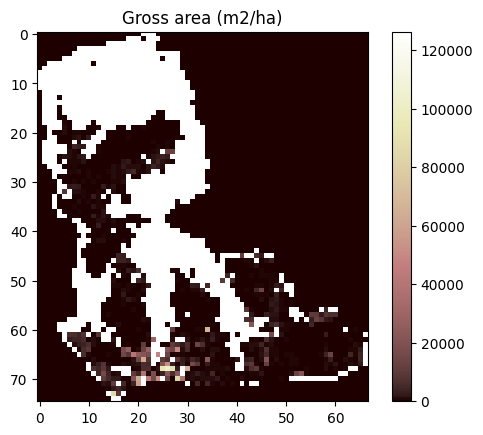

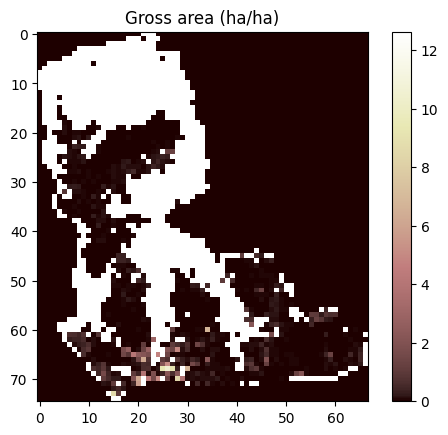

In [ ]:
# read the outcome rasters
grossarea_100m_r = rasterio.open('images/grossarea_100m.tif')
print(grossarea_100m_r)

# Plot the image
grossarea_100m_img = grossarea_100m_r.read(1)

plt.imshow(grossarea_100m_img, cmap='pink')
plt.colorbar()
plt.title('Gross area (m2/ha)') # 이 데이터가 100 m * 100 m 래스터이기 때문에 단위는 m2/ha
plt.show()

plt.imshow(grossarea_100m_img / 1E4  , cmap='pink')
plt.colorbar()
plt.title('Gross area (ha/ha)') # ha/ha 로 해 봄
plt.show()

In [ ]:
# Read MI table

# 이름으로 불러오기
# pd.read_excel('경로/파일명.xlsx', sheet_name = '시트명')
MI_tb = pd.read_excel('Data/MI by structure_v2.xlsx', sheet_name = 'MI')
MI_tb = MI_tb.fillna(0) # NaN을 0으로 바꿔주자
print(MI_tb)

   Code                       Name  Brick_kgm2  Mortar_kgm2  Block_kgm2  \
0    11                      Brick       262.5       152.25         0.0   
1    12                      Block         0.0        49.35       525.0   
2    19    Other masonry structure         0.0         0.00         0.0   
3    21        Reinforced concrete         0.0         0.00         0.0   
4    31                      Steel         0.0         0.00         0.0   
5    40  Steel reinforced concrete         0.0         0.00         0.0   
6    41             Steel concrete         0.0         0.00         0.0   
7    42  Steel reinforced concrete         0.0         0.00         0.0   
8    51                       Wood         0.0         0.00         0.0   
9    99                      Other         0.0         0.00         0.0   

   Concrete_m3m2  Rebar_kgm2  SteelFrame_kgm2  StructuralMaterial_m3m2  \
0        0.00000    0.000000              0.0                 0.000000   
1        0.00000    0.0000

MI와 Embedded Carbon사이의 관계식을 엑셀에서 읽어들이고 내재탄소량 계산

In [ ]:
EC_tb = pd.read_excel('Data/MI by structure_v2.xlsx', sheet_name = 'GWP')
EC_tb = EC_tb.fillna(0) # NaN을 0으로 바꿔주자
print(EC_tb)


             Material  Coefficient         Unit     세부자재  \
0               Brick        0.398  kgCO2-eq/kg     점토벽돌   
1              Mortar        0.926  kgCO2-eq/kg     모르타르   
2               Block        0.123  kgCO2-eq/kg   콘크리트블록   
3            Concrete      241.000  kgCO2-eq/m3      레미콘   
4               Rebar        0.438  kgCO2-eq/kg       철근   
5          SteelFrame        0.429  kgCO2-eq/kg       철골   
6  StructuralMaterial      818.000  kgCO2-eq/m3  구조재(각재)   
7                 OSB      818.000  kgCO2-eq/m3       합판   

                       DB명  Reference  개발연도  \
0         점토벽돌(Clay brick)  국가 LCI DB  2018   
1              1종 포틀랜드 시멘트  국가 LCI DB  2017   
2  콘크리트 벽돌(Concrete Brick)  국가 LCI DB  2018   
3         레디믹스트 콘크리트 25-24  국가 LCI DB  2018   
4                   철근생산공정  국가 LCI DB  2002   
5                   형강생산공정  국가 LCI DB  2002   
6              합판(Plywood)  국가 LCI DB  2005   
7              합판(Plywood)  국가 LCI DB  2005   

                                   

In [ ]:
# Carbon from Concrete

EC_concrete = EC_tb.loc[EC_tb.Material == "Concrete",:] # slicing pandas dataframe
print(EC_concrete)





   Material  Coefficient         Unit 세부자재               DB명  Reference  개발연도  \
3  Concrete        241.0  kgCO2-eq/m3  레미콘  레디믹스트 콘크리트 25-24  국가 LCI DB  2018   

                                               비고  
3  보고서 : 166, Total : 241, ezEPD : , ecoinvent :   


In [ ]:
EC_concrete.__class__

pandas.core.frame.DataFrame

In [ ]:
# Slicing the EC table

ec_tmp1 = EC_concrete['Coefficient']

# or

ec_tmp2 = EC_tb.loc[EC_tb.Material == "Concrete", 'Coefficient']

print(ec_tmp1)
print(ec_tmp2)




3    241.0
Name: Coefficient, dtype: float64
3    241.0
Name: Coefficient, dtype: float64


In [ ]:
# Gross-area by Structure
code_v = np.array(MI_tb.loc[ : ,'Code']  )
print(code_v)

print(code_v[3])


[11 12 19 21 31 40 41 42 51 99]
21


In [ ]:

grossarea_21 = grossarea_100m_img * (code_img == 21)
# or
grossarea_21_rep = grossarea_100m_img * (code_img == code_v[3]) # Python에서는 인덱스가 0부터 시작. 4번째 값이니까 0, 1, 2, 3 해서 '3'을 입력해야 철근콘크리트 코드 선택됨


grossarea_21 == grossarea_21_rep # 값을 비교해 봄. 동일하다.


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
# Pandas dataframe에서 슬라이스된 값을 곱할 때 에러가 났음. Numpy array로 변환하여 해결
# ref: https://stackoverflow.com/questions/63220314/typeerror-cant-multiply-sequence-by-non-int-of-type-numpy-float64-in-machine

concrete_21_m3 = grossarea_21 * np.array(MI_tb.loc[MI_tb.Code == 21,'Concrete_m3m2']  )
rebar_21_kg = grossarea_21  * np.array(MI_tb.loc[MI_tb.Code == 21,'Rebar_kgm2']  )





In [ ]:
# Carbon으로 컨버전 해 보자
# carbon_21_concrete = concrete_21_m3 * ec_tmp2 # error, why?

ValueError: ignored

In [ ]:
carbon_21_concrete = concrete_21_m3 * np.array(ec_tmp2) # np.array 함수로 감싸 줘서 해결

In [ ]:
# 한 번에 해 봅시다
# 21번 구조에서 콘크리트에 내재된 탄소 (Kg CO2 eq)
carbon_21_concrete_kgCO2 = grossarea_21 * np.array(MI_tb.loc[MI_tb.Code == 21,'Concrete_m3m2']) * np.array(EC_tb.loc[EC_tb.Material == "Concrete",'Coefficient'])
# 철근에 내재된 탄소
carbon_21_rebar_kgCO2 = grossarea_21  * np.array(MI_tb.loc[MI_tb.Code == 21,'Rebar_kgm2']  )* np.array(EC_tb.loc[EC_tb.Material == "Rebar",'Coefficient'])


# 합
carbon_21_total_kgCO2 = carbon_21_concrete_kgCO2 + carbon_21_rebar_kgCO2


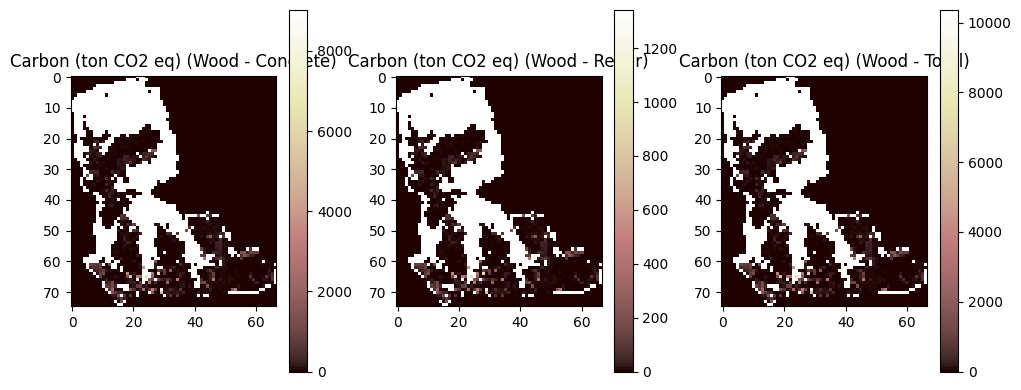

In [ ]:
# 내재탄소량 플로팅

nrow = 1
ncol = 3

plt.figure(figsize=(10,4))
plt.subplot(nrow, ncol, 1)
plt.imshow(carbon_21_concrete_kgCO2 / 1000.0,  cmap='pink')
plt.colorbar()
plt.title('Carbon (ton CO2 eq) (Wood - Concrete)')

plt.subplot(nrow, ncol, 2)
plt.imshow(carbon_21_rebar_kgCO2 / 1000.0,  cmap='pink')
plt.colorbar()
plt.title('Carbon (ton CO2 eq) (Wood - Rebar)')

plt.subplot(nrow, ncol, 3) # 3번째 컬럼
plt.imshow(carbon_21_total_kgCO2 / 1000.0,  cmap='pink')
plt.colorbar()
plt.title('Carbon (ton CO2 eq) (Wood - Total)')


plt.tight_layout()
plt.show()


In [ ]:
print("Carbon for Wood = " + str(np.nansum(carbon_21_total_kgCO2)/1000.0) + " (ton)")


Carbon for Wood = 257523.1634676 (ton)


In [ ]:
# Save the outcomes to file

carbon_concrete_code21_out_fn = './images/Carbon_Code21_Concrete_100m.tif'

with rasterio.open(carbon_concrete_code21_out_fn, 'w+', **out_meta_float64) as dst:
    dst.write_band(1, carbon_21_concrete_kgCO2)

carbon_rebar_code21_out_fn = './images/Carbon_Code21_Rebar_100m.tif'

with rasterio.open(carbon_rebar_code21_out_fn, 'w+', **out_meta_float64) as dst:
    dst.write_band(1, carbon_21_rebar_kgCO2)

carbon_total_code21_out_fn = './images/Carbon_Code21_Total_100m.tif'

with rasterio.open(carbon_total_code21_out_fn, 'w+', **out_meta_float64) as dst:
    dst.write_band(1, carbon_21_total_kgCO2)



os.listdir('images')

['rasterized.tif',
 'Builtup_Jongno-gu.png',
 'Builtup_Jongno-gu_Feb2023.png',
 'height_100m.tif',
 'area_100m.tif',
 'volume_100m.tif',
 'code_100m.tif',
 'Stock_Code21_Concrete_100m.tif',
 'Stock_Code21_Rebar_100m.tif',
 'grossarea_100m.tif',
 'Carbon_Code21_Concrete_100m.tif',
 'Carbon_Code21_Rebar_100m.tif',
 'Carbon_Code11_brick_100m.tif',
 'Carbon_Code11_mortar_100m.tif',
 'Carbon_Code21_Total_100m.tif']

이제는 루프를 만들어서 전체 구조에 대해 한 번에 batch로 처리하는 루틴을 작성해 보자.

In [ ]:
# 위에서 만든 구조 코드 출력
print(code_v)

print(len(code_v)) # length of the vector
# 10
print(range(len(code_v))) # length to sequence

# 0에서 9 까지 순회
for i in range(len(code_v)):
    print("item ", i, "=", code_v[i])



[11 12 19 21 31 40 41 42 51 99]
10
range(0, 10)
item  0 = 11
item  1 = 12
item  2 = 19
item  3 = 21
item  4 = 31
item  5 = 40
item  6 = 41
item  7 = 42
item  8 = 51
item  9 = 99


In [ ]:
# for loop를 순회하면서 구조 코드 별로 처리해 보자
# 사실 Pythonic 한 방법은 아닌데, 이해가 쉽도록 for loop 형태로 해 봄.

mt_v = EC_tb.Material


for code_idx in range(len(code_v)):
  code_tmp = code_v[code_idx]
  grossarea_tmp = grossarea_100m_img * (code_img == code_tmp)

  # 각 구조 코드 별 물질은 이런 식으로 하나씩 해도 되지만
  # concrete_tmp_m3 = grossarea_tmp * np.array(MI_tb.loc[MI_tb.Code == code_tmp,'Concrete_m3m2']  )

  # 전체 물질을 한 번에 처리하면 편함
  # 해당 구조에 대한 물질계수 전체. 포함되지 않는 물질의 경우 0이 됨
  print("Code", code_tmp)
  mi_tmp = MI_tb.loc[MI_tb.Code == code_tmp, ]

  # print(mi_tmp)

  mi_tmp2 = np.array(mi_tmp)[0,2:] # 우리는 3번째 아이템 부터 필요함. numpy array로 변환하니 편리하다.
  # print(mi_tmp2)

  # a placeholder for total embodied carbon
  co2eq_total_tmp = grossarea_100m_img # clone the area raster
  co2eq_total_tmp.fill(0.0)  # fill with zero

  for mt_idx in range(len(mt_v)):

    # MI 테이블 슬라이싱

    mt_tmp = mt_v[mt_idx]
    # print(mt_tmp)

    ec_tmp = EC_tb.loc[EC_tb.Material == mt_tmp, 'Coefficient']
    # print(ec_tmp)

    # 우리의 경우 MI테이블과 EC에서 물질 순서가 일치함. 편리하다..
    material_tmp = grossarea_tmp * mi_tmp2[mt_idx]
    co2eq_tmp = material_tmp * np.array(ec_tmp[mt_idx])

    # 래스터 이미지 저장
    material_out_tmp_fn = './images/Material_' + mt_tmp + '_Code' + str(code_tmp) + '_100m.tif'
    with rasterio.open(material_out_tmp_fn, 'w+', **out_meta_float64) as dst:
      dst.write_band(1, material_tmp)

    carbon_out_tmp_fn = './images/Carbon_Code' + str(code_tmp) + '_' + mt_tmp + '_100m.tif'
    with rasterio.open(carbon_out_tmp_fn, 'w+', **out_meta_float64) as dst:
      dst.write_band(1, co2eq_tmp)

    # accumulate total CO2eq
    co2eq_total_tmp = co2eq_total_tmp + np.nan_to_num(co2eq_tmp, nan=0.0) # 합산하기 전에 nan을 0으로 바꿔줬음

  # 여기 오면 위에 두 번째 루프는 끝났음. 첫 번째 루프는 안 끝났음.
  # Python에서는 들여쓰기(indentation)으로 루프 영역을 지정
  carbon_total_out_tmp_fn = './images/Carbon_Code' + str(code_tmp) + '_total_100m.tif'
  with rasterio.open(carbon_total_out_tmp_fn, 'w+', **out_meta_float64) as dst:
    dst.write_band(1, co2eq_total_tmp)

# 여기까지 오면 첫번째 루프도 끝났음



# 여하튼 위에 반복문(for-loop)가 굉장히 좋은 코딩은 아님. 가독성 위주..

Code 11
[262.5 152.25 0.0 0.0 0.0 0.0 0.0 0.0]
Code 12
[0.0 49.35 525.0 0.0 0.0 0.0 0.0 0.0]
Code 19
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
Code 21
[0.0 0.0 0.0 0.55 45.0 0.0 0.0 0.0]
Code 31
[0.0 0.0 0.0 0.25 21.0 55.0 0.0 0.0]
Code 40
[0.0 0.0 0.0 0.45 70.0 80.0 0.0 0.0]
Code 41
[0.0 0.0 0.0 0.45 70.0 80.0 0.0 0.0]
Code 42
[0.0 0.0 0.0 0.45 70.0 80.0 0.0 0.0]
Code 51
[0.0 0.0 0.0 0.42884024868286524 34.30940800268597 0.0 0.19580476029999053
 0.04780624086804449]
Code 99
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
